# Optimizacion con MAPL

In [11]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mu
import nibabel as nib
from mapmri import mapmri
from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)

Populating the interactive namespace from numpy and matplotlib


<module 'utils.img_utils' from 'utils/img_utils.pyc'>

In [2]:
def load_subject(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        gtab = gradient_table(bvals=bvals[bvalpos], bvecs=bvecs[:,bvalpos])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        gtab = gradient_table(bvals=bvals, bvecs=bvecs)
    return img, gtab

def get_sample(index, numbers, bval=None, bvalpos=None,  scale=2):
    img, gtab = load_subject(index, numbers, bval, bvalpos)
    lr, lr_affine = img_utils.downsampling(img, scale)
    return img.get_data(), lr

def get_sample_maker(numbers, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, bval, bvalpos,  scale)

def mm(A):
    return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition

expectativa:

$ \min_{Y^{hr},C} \{ ||GY^{lr} - Y^{hr}||^2 + || Y^{lr} - S_0*\phi*C||^2 \}$


realidad:


$ \min_{Y^{hr},C} \{ ||GY^{lr} - Y^{hr}||^2 + \sum_{i}^{vhr} || (Y^{lr}_{i}, Y^{lr}_{i+1vhr}, Y^{lr}_{i+2vhr}, Y^{lr}_{i+3vhr}, Y^{lr}_{i+4vhr},Y^{lr}_{i+5vhr}) - S_0*\phi*C_{i}||^2 \}$

In [24]:

def mapl_parameters(gtab):
    radial_order = 6
    map_model = mapmri.MapmriModel(gtab,
                                radial_order=radial_order,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)


    mu = map_model.mu
    tau = 1 / (4 * np.pi ** 2) # hasta encontrar el big y small delta en HCP
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = gtab.bvecs * qvals[:, None]
    M = mapmri.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return M


def define_problem_with_mapl_primeraQAnduvoBien(i_lr, i_hr_shape, downsampling_matrix, gtab, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    vhrb = Nx*Ny*Nz*bval
    vlr = Nx*Ny*Nz/(scale**3)
    vhr = Nx*Ny*Nz
      
    Yhr = cvx.Variable(vhrb, 1)
    #Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    G = cvx.Parameter(vlr*bval, vhrb)
    G.value = downsampling_matrix

    # MAPL params
    S0 = cvx.Parameter()
    S0.value = 100    
    M = cvx.Parameter(bval, 50)
    M.value = mapl_parameters(gtab)
    C = cvx.Variable(Nx*Ny*Nz, 50)
    
    mapl = sum([cvx.sum_squares( M*C[i,:].T - Yhr[i:vhrb:vhr]) for i in xrange(vhr)])
    
    # Form objective.
    obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr) + mapl)

    # Create two constraints.
    #constraints = [Yhr >= 0]

    # Form and solve problem.
    prob = cvx.Problem(obj)
    return prob, Yhr, Ylr, G


def define_problem_with_mapl(i_lr, i_hr_shape, downsampling_matrix, gtab, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    vhrb = Nx*Ny*Nz*bval
    vlr = Nx*Ny*Nz/(scale**3)
    vhr = Nx*Ny*Nz
      
    Yhr = cvx.Variable(vhrb, 1)
    #Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    G = cvx.Parameter(vlr*bval, vhrb)
    G.value = downsampling_matrix

    # MAPL params
    S0 = cvx.Parameter()
    S0.value = 100    
    M = cvx.Parameter(bval, 50)
    M.value = mapl_parameters(gtab)
    C = cvx.Variable(Nx*Ny*Nz, 50)
    
    #mapl = sum([cvx.sum_squares(M*C[i,:].T - Yhr[i:vhrb:vhr]) for i in xrange(vhr)])
    #Yhr_mapl = cvx.vstack([M*C[i,:].T for i in xrange(vhr)])
    epsilon = cvx.Parameter()
    epsilon.value = (np.linalg.norm(i_lr)**2)*0.9
    print "EPSILON = ", epsilon.value
    mapl_eq = [cvx.sum_squares(M*C[i,:].T-Yhr[i:vhrb:vhr]) <= epsilon for i in xrange(vhr)]
    
    # Form objective.
    obj = cvx.Minimize(cvx.sum_squares(G*Yhr - Ylr))

    # Create two constraints.
    #constraints = [Yhr >= 0, mapl <= epsilon*vhr*bval]

    # Form and solve problem.
    prob = cvx.Problem(obj, mapl_eq)
    return prob, Yhr, Ylr, G

"""
NOTAS:
 - la primera formulacion funciono bastante bien (con la sum de los sum_squears) fue 
   sacado el metodo para preservarlo
 - probe con la lista de constraints de mapl con igualdad dio todos infeasibles
   (proximo a probar lo mismo con desigualdad a un epsilon en vez de igualdad)
 - 
   
"""


'\nNOTAS:\n - la primera formulacion funciono bastante bien (con la sum de los sum_squears) fue \n   sacado el metodo para preservarlo\n - probe con la lista de constraints de mapl con igualdad dio todos infeasibles\n   (proximo a probar lo mismo con desigualdad a un epsilon en vez de igualdad)\n - \n   \n'

In [9]:
def solveMin(i_lr, i_hr_shape, downsampling_matrix, gtab, scale=2, max_iters=1500, verbose=False):
    #prob, Yhr, Ylr, G = define_problem(i_lr, i_hr_shape, downsampling_matrix, scale)
    #prob, Yhr, Ylr, G = define_problem_with_tv(i_lr, i_hr_shape, downsampling_matrix, scale)
    prob, Yhr, Ylr, G = define_problem_with_mapl(i_lr, i_hr_shape, downsampling_matrix, gtab, scale)
       
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.00e-01, verbose=verbose )  # Returns the optimal value.
    #res = prob.solve(solver='ECOS', verbose=verbose )  # Returns the optimal value.
    """
        'max_iters'
            maximum number of iterations (default: 100).
        'abstol'
            absolute accuracy (default: 1e-7).
        'reltol'
            relative accuracy (default: 1e-6).
        'feastol'
            tolerance for feasibility conditions (default: 1e-7).
        'abstol_inacc'
            absolute accuracy for inaccurate solution (default: 5e-5).
        'reltol_inacc'
            relative accuracy for inaccurate solution (default: 5e-5).
        'feastol_inacc'
            tolerance for feasibility condition for inaccurate solution (default: 1e-4). 
    """
    
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    if Yhr.value is None :
        #Yhr.value = np.ones(i_hr_shape)
        print 'FRECONSTRUCTION FAIL :('
        A = np.zeros(i_hr_shape,dtype='float32')
    else:    
        A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
        
    return A, seg, prob


## Solving the problem and cross-validation (leave one out)

== Leaving out: # 180937
SAMPLES min/max  29.1264362335 2830.05957031 12.4889230728 3112.2512207
= Training and fiting ...
= Solving optimization problem ...
WARN: m less than n, problem likely degenerate
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 13970882, CG tol ~ 1/iter^(2.00)
eps = 1.00e-01, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 98497, constraints m = 16850
Cones:	linear vars: 1728
	soc vars: 15122, soc blks: 1729
Setup time: 7.28e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf  

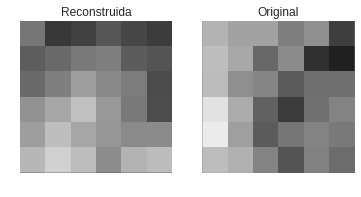

In [25]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(img_utils)

RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
# Esto es para quedame con la gtab que es igua a todos
img, gtab = load_subject(0,subjects, bval=2000, bvalpos=bvals2000pos)
del img
sample_maker = get_sample_maker(subjects, bval=2000, bvalpos=bvals2000pos, scale=2)

n_samples = 6
iterations = 6

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

base_folder = RES_BASE_FOLDER
#base_folder = None

for i in range(0, iterations):
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    subjects.append(subjects.pop(0))
    lr_samples, hr_samples = buildT(sample_maker, n_samples) #lr, hr

    #lr_samples, hr_samples = lr_samples/1589, hr_samples/1589
    print 'SAMPLES min/max ', lr_samples.min(),lr_samples.max(),  hr_samples.min(), hr_samples.max()
    
    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train(hr_samples, lr_samples)
    regr.coef_ = csr_matrix(regr.coef_)
    
    # Reshape the one that left out to validate
    i_lr = lr_test.reshape(voi_lr_shape, order='F')
    i_hr = hr_test.reshape(voi_hr_shape, order='F')
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, seg, prob = solveMin(i_lr, i_hr.shape, regr.coef_, gtab, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    B = (regr.coef_*i_hr.reshape(-1, order='F')).reshape(voi_lr_shape, order='F')
    max_vals_lr_r.append(B.max())
    min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    dif_norm_lr = np.linalg.norm(i_lr-B)
    Ylr_norm = np.linalg.norm(B)
    Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)
